In [1]:
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd

## Dams shapefile

In [2]:
reservoirsShapefilePath = '/home/lamductan/Hydroviet/github/DataNotebook/reservoirsShapefile/'
hydrobasinPath = reservoirsShapefilePath + 'hydrobasinl6se-asia'
hydropowerReservoirsPath = reservoirsShapefilePath + 'hydropowerreservoirs'
mekongDamsPath = reservoirsShapefilePath + 'mekongdamsgms'

In [3]:
hydrobasin = gpd.read_file(hydrobasinPath)
hydropowerReservoirs = gpd.read_file(hydropowerReservoirsPath)
mekongDams = gpd.read_file(mekongDamsPath)

hydrobasin = hydrobasin.to_crs({'init': 'epsg:4326'})
hydropowerReservoirs = hydropowerReservoirs.to_crs({'init': 'epsg:4326'})
mekongDams = mekongDams.to_crs({'init': 'epsg:4326'})

## Reservoirs shapefile

In [4]:
aoi2Path = reservoirsShapefilePath + 'aoi2reservoirs'
aoi2Reservoirs = gpd.read_file(aoi2Path)

reservoirsShapefile = {}
reservoirsShapefile['VNM'] = aoi2Reservoirs[aoi2Reservoirs['COUNTRY'] =='Vietnam']
reservoirsShapefile['LAO'] = aoi2Reservoirs[aoi2Reservoirs['COUNTRY'] =='Laos']
reservoirsShapefile['THA'] = aoi2Reservoirs[aoi2Reservoirs['COUNTRY'] =='Thailand']

In [5]:
mekongReservoirsAndDams = aoi2Reservoirs.copy()
mekongReservoirsAndDams = mekongReservoirsAndDams.append(mekongDams)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


## Rivers shapefile

In [6]:
riversShapefilePath = '/home/lamductan/Hydroviet/github/DataNotebook/reservoirsShapefile/'
laRiversPath = riversShapefilePath + 'laorivers'
vnRiversPath = riversShapefilePath + 'vnrivers'
tlRiversPath = riversShapefilePath + 'tlrivers'
cbRiversPath = riversShapefilePath + 'cbrivers'

In [7]:
riversShapefile = {}
riversShapefile['VNM'] = gpd.read_file(vnRiversPath)
riversShapefile['LAO'] = gpd.read_file(laRiversPath)
riversShapefile['THA'] = gpd.read_file(tlRiversPath)
riversShapefile['KHM'] = gpd.read_file(cbRiversPath)

In [8]:
'''
rivers = riversShapefile['VNM'].copy()
rivers = rivers.append(riversShapefile['LAO'])
rivers = rivers.append(riversShapefile['THA'])
rivers = rivers.append(riversShapefile['KHM'])
'''
rivers = gpd.read_file(reservoirsShapefilePath + 'gmsriversadb')

## Countries shapefile

In [9]:
countryShapefilePath = '/home/lamductan/Hydroviet/github/DataNotebook/CountryShapefile/'
vnShapefilePath = countryShapefilePath + 'vnShapefile/VNM_adm1.shp'
laShapefilePath = countryShapefilePath + 'laShapefile/LAO_adm1.shp'
cbShapefilePath = countryShapefilePath + 'cbShapefile/KHM_adm1.shp'
tlShapefilePath = countryShapefilePath + 'tlShapefile/THA_adm1.shp'

In [10]:
countryShapefile = {}
countryShapefile['VNM'] = gpd.read_file(vnShapefilePath)
countryShapefile['LAO'] = gpd.read_file(laShapefilePath)
countryShapefile['KHM'] = gpd.read_file(cbShapefilePath)
countryShapefile['THA'] = gpd.read_file(tlShapefilePath)

In [11]:
mekongCountriesShapefile = countryShapefile['VNM'].copy()
mekongCountriesShapefile = mekongCountriesShapefile.append(countryShapefile['LAO'])
mekongCountriesShapefile = mekongCountriesShapefile.append(countryShapefile['KHM'])
mekongCountriesShapefile = mekongCountriesShapefile.append(countryShapefile['THA'])

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


## Overlay countries, rivers, reservoirs and dams

In [12]:
def overlayRiversReservoirsDams(countryShapefile, 
                                riversShapefile=None, 
                                reservoirsShapefile=None, 
                                damsShapefile=None, 
                                ax=None, 
                                figsize=20, 
                                reservoirScale=1.0):
    
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape, box, Point
    from shapely.affinity import scale
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure(figsize = (figsize,figsize))
        ax = fig.add_subplot(111)

    shapes = [shape(p) for p in countryShapefile['geometry']]
    mp = MultiPolygon(shapes)
    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for provinceShape in shapes:
        patches.append(PolygonPatch(provinceShape, fc='none', ec='#555555', zorder=0))
    
    if riversShapefile is not None:
        for riverShapefile in riversShapefile['geometry']:
            bounds = riverShapefile.bounds
            rectBox = box(*bounds)
            p = riverShapefile.buffer(0.001)
            patches.append(PolygonPatch(p, fc='aqua', ec='aqua', zorder=1))
    
    if reservoirsShapefile is not None:
        for reservoirShapefile in reservoirsShapefile['geometry']:
            p = shape(reservoirShapefile)
            p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    if damsShapefile is not None:
        for damShapefile in damsShapefile['geometry']:
            p = shape(damShapefile)
            p = p.buffer(0.05)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    ax.axis('off')
    
    plt.show()
    return ax


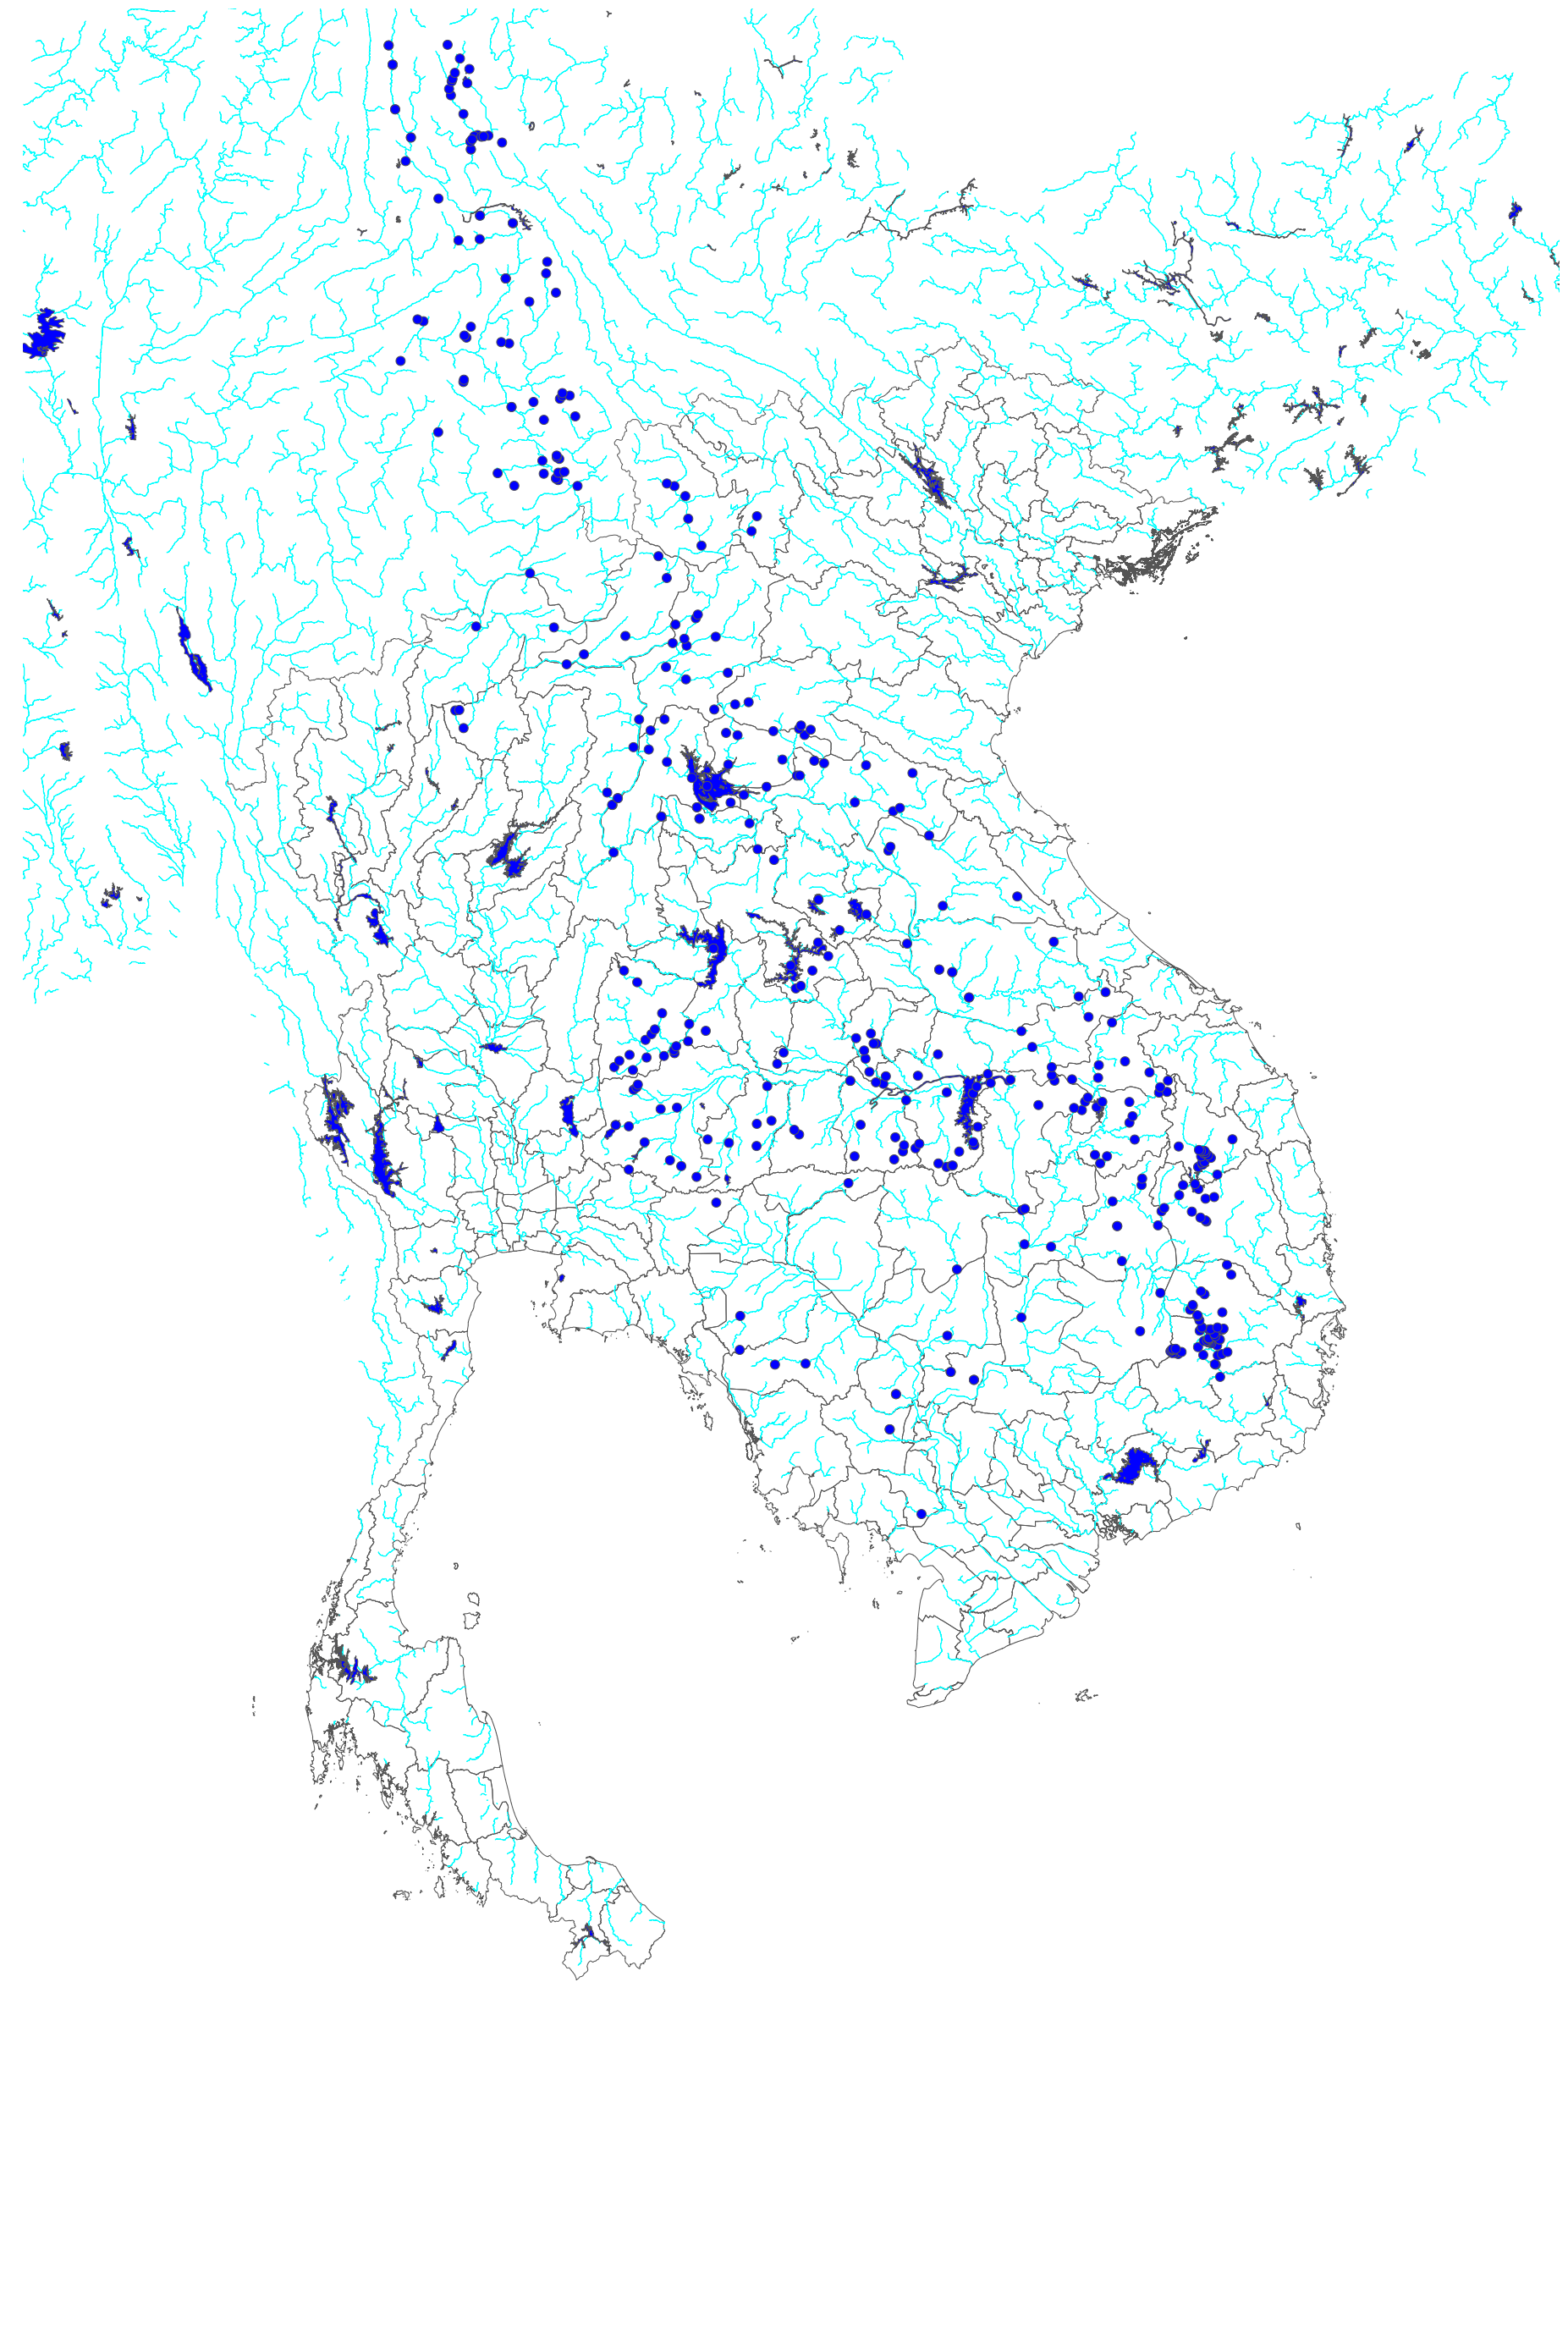

In [13]:
overlayRiversReservoirsDams(countryShapefile=mekongCountriesShapefile,
                           riversShapefile=rivers,
                           reservoirsShapefile=aoi2Reservoirs,
                           damsShapefile=mekongDams,
                           figsize=50,
                           reservoirScale=2.0)

## Find reservoirs and dams lay on each river in gmsriversadb shapefile.

In [14]:
import os

reservoirsAndDamsPerRiver = []

if not os.path.isfile('reservoirsAndDamsPerRiver.txt'):
    import time
    start = time.time()

    with open('reservoirsAndDamsPerRiver.txt', 'w') as f:
        for i in range(rivers.shape[0]):
            f.write(str(i))
            t = time.time()
            currentRiver = rivers.iloc[i]['geometry']
            reservoirsAndDamsCurrentRiver = []
            for j in range(mekongReservoirsAndDams.shape[0]):
                currentWater = mekongReservoirsAndDams.iloc[j]['geometry']
                if currentRiver.intersects(currentWater):
                    reservoirsAndDamsCurrentRiver.append(j)
                    f.write(',' + str(j))
            reservoirsAndDamsPerRiver.append(reservoirsAndDamsCurrentRiver)
            if i % 100 == 0:
                timeElapsed = time.time() - t
                print(i, end = '     ')
                print('Time elapsed %d' % timeElapsed)
            f.write('\n')

        timeElapsed = time.time() - start
        print('Time elapsed %d' % timeElapsed)
    
    f.close()

else:
    with open('reservoirsAndDamsPerRiver.txt', 'r') as f:
        for line in f.readlines():
            line = line.strip('\n\r')
            data = line.split(',')
            if len(data) == 1:
                reservoirsAndDamsPerRiver.append([])
            else:
                reservoirsAndDamsCurrentRiver = [int(data[i]) for i in range(1, len(data))]
                reservoirsAndDamsPerRiver.append(reservoirsAndDamsCurrentRiver)
    f.close()

### Print rivers' name and list of reservoirs and dams on them

In [15]:
for i in range(len(reservoirsAndDamsPerRiver)):
    if (len(reservoirsAndDamsPerRiver[i])) > 0:
        print('{} - {}: '.format(i, rivers.iloc[i]['Sub_Name']), end = '')
        print(reservoirsAndDamsPerRiver[i])
        for index in reservoirsAndDamsPerRiver[i]:
            print('{}, '.format(mekongReservoirsAndDams.iloc[index]['local_name']), end = '')
        print()

30 - Zou Jiang4: [53]
nan, 
43 - Zou Jiang1: [50]
nan, 
50 - Yu Jiang1: [47]
nan, 
51 - Yu Jiang1: [47]
nan, 
53 - Yu Jiang1: [47]
nan, 
54 - Yu Jiang1: [48]
nan, 
85 - Wuli Jiang /  Nanliu Jiang: [54]
nan, 
91 - Wuli Jiang /  Nanliu Jiang: [56]
nan, 
157 - Song Bo1: [108]
nan, 
166 - Chay: [107]
nan, 
167 - Chay: [107]
nan, 
604 - Lake Inle: [69]
nan, 
605 - Lake Inle: [69]
nan, 
606 - Lake Inle: [69]
nan, 
702 - Zawgyi: [64]
nan, 
796 - Yin: [66]
nan, 
797 - Yin: [66]
nan, 
798 - Yin: [66]
nan, 
810 - Irrawaddy3: [68]
nan, 
966 - Nam Ngum: [57]
nan, 
967 - Nam Ngum: [57]
nan, 
968 - Nam Ngum: [57]
nan, 
969 - Nam Ngum: [57]
nan, 
971 - Nam Ngum: [57]
nan, 
1037 - Songkhram: [80]
nan, 
1096 - Nam Kam / Nam Hinboun / Huai: [82]
nan, 
1100 - Nam Kam / Nam Hinboun / Huai: [82]
nan, 
1102 - Nam Kam / Nam Hinboun / Huai: [82]
nan, 
1123 - Nam Chi: [84]
nan, 
1124 - Nam Chi: [84]
nan, 
1125 - Nam Chi: [85]
nan, 
1126 - Nam Chi: [85]
nan, 
1128 - Nam Chi: [84]
nan, 
1129 - Nam Chi: [84]
nan,

## Plot some specific rivers you want. List them in listRiverName

In [16]:
def overlayRiversReservoirsDams_2(countryShapefile, 
                                riversShapefile=None, 
                                reservoirsShapefile=None, 
                                damsShapefile=None, 
                                ax=None, 
                                figsize=20, 
                                reservoirScale=1.0,
                                listRiverName=None):
    
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape, box, Point
    from shapely.affinity import scale
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure(figsize = (figsize,figsize))
        ax = fig.add_subplot(111)

    shapes = [shape(p) for p in countryShapefile['geometry']]
    mp = MultiPolygon(shapes)
    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for provinceShape in shapes:
        patches.append(PolygonPatch(provinceShape, fc='none', ec='#555555', zorder=0))
    
    if riversShapefile is not None:
        for i in range(riversShapefile.shape[0]):
            riverShapefile = riversShapefile.iloc[i]
            if listRiverName is not None:
                if riverShapefile['Sub_Name'] in listRiverName:
                    riverShapefile = riverShapefile['geometry']
                    bounds = riverShapefile.bounds
                    rectBox = box(*bounds)
                    p = riverShapefile.buffer(0.001)
                    patches.append(PolygonPatch(p, fc='aqua', ec='aqua', zorder=1))
    
    if reservoirsShapefile is not None:
        for reservoirShapefile in reservoirsShapefile['geometry']:
            p = shape(reservoirShapefile)
            p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    if damsShapefile is not None:
        for damShapefile in damsShapefile['geometry']:
            p = shape(damShapefile)
            p = p.buffer(0.05)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    ax.axis('off')
    
    plt.show()
    return ax


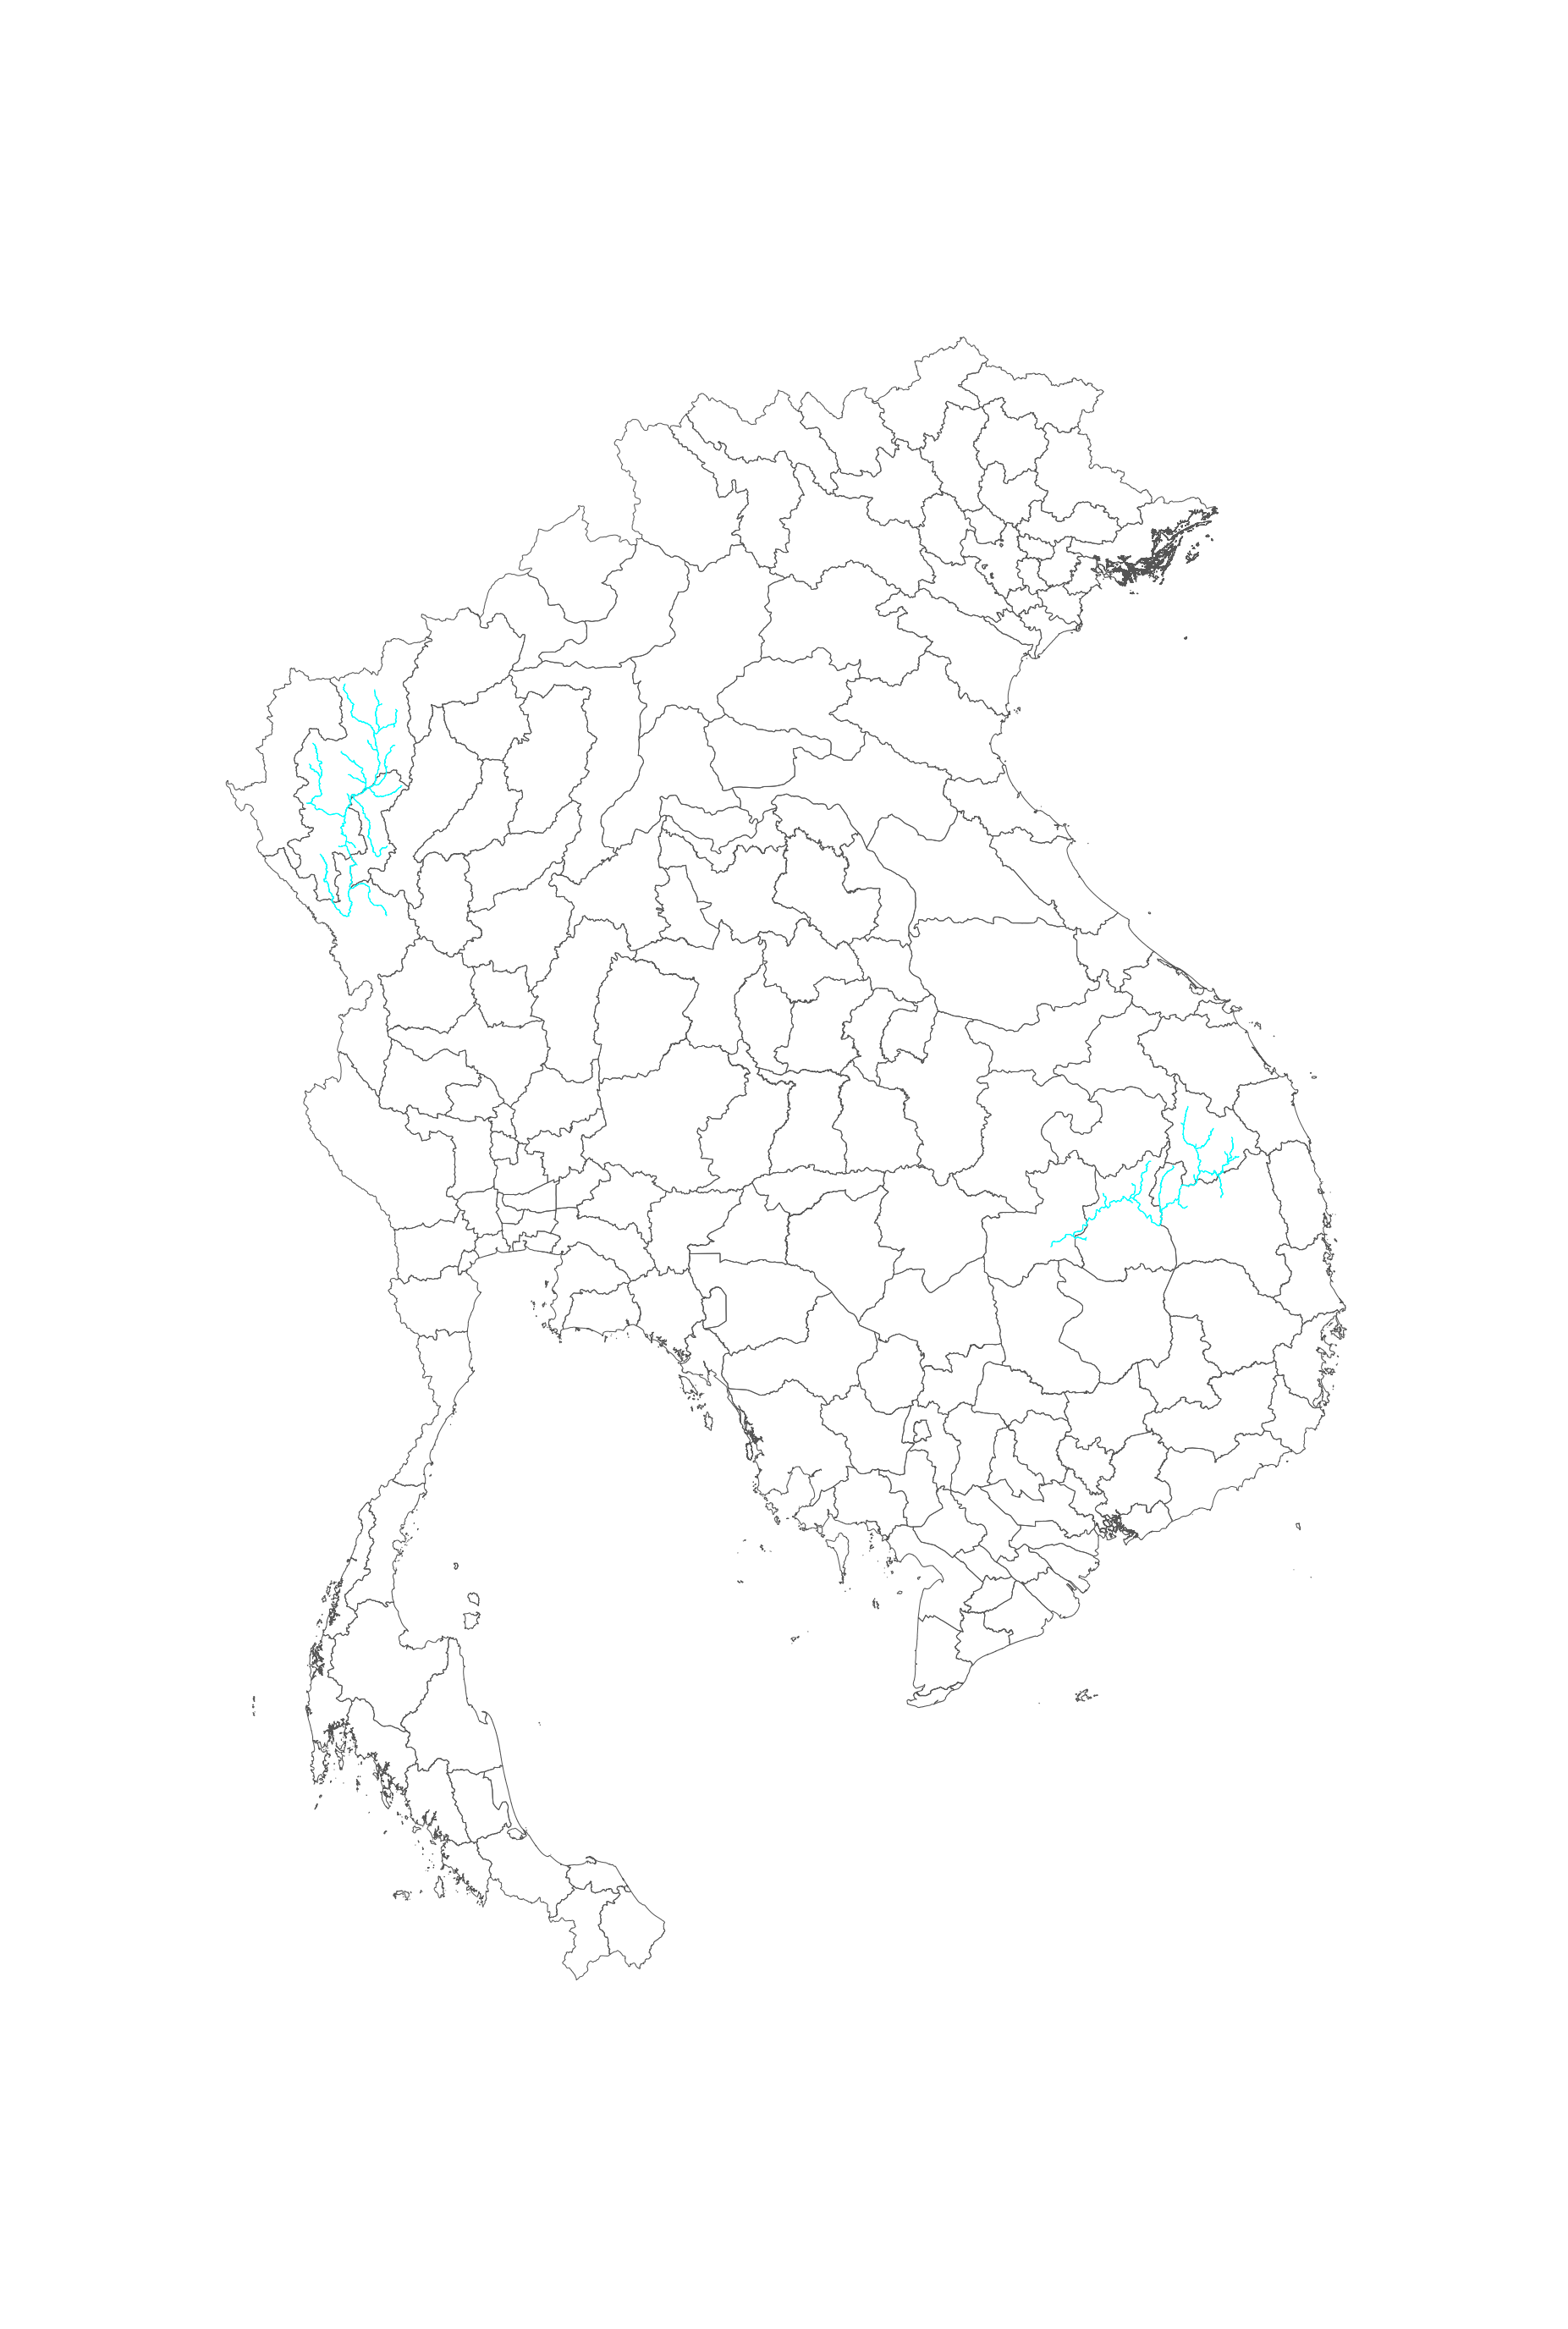

In [17]:
overlayRiversReservoirsDams_2(countryShapefile=mekongCountriesShapefile,
                           riversShapefile=rivers,
                           figsize=50,
                           reservoirScale=2.0,
                           listRiverName=['Se San', 'Mae Nam Wang'])

### Many of rivers do not have any reservoirs. Very few reservoirs and dams lay on the same river.

In [18]:
print(reservoirsAndDamsPerRiver)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [53], [], [], [], [], [], [], [], [], [], [], [], [], [50], [], [], [], [], [], [], [47], [47], [], [47], [48], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [54], [], [], [], [], [], [56], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [108], [], [], [], [], [], [], [], [], [107], [107], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

In [19]:
def overlayRiversReservoirsDams_3(countryShapefile, 
                                riversShapefile=None, 
                                reservoirsShapefile=None, 
                                ax=None, 
                                figsize=20, 
                                reservoirScale=1.0,
                                listRiverName=None,
                                reservoirsAndDamsPerRiver=None):
    
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape, box, Point
    from shapely.affinity import scale
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure(figsize = (figsize,figsize))
        ax = fig.add_subplot(111)

    shapes = [shape(p) for p in countryShapefile['geometry']]
    mp = MultiPolygon(shapes)
    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    patches = []
    for provinceShape in shapes:
        patches.append(PolygonPatch(provinceShape, fc='none', ec='#555555', zorder=0))
    
    if riversShapefile is not None:
        for i in range(riversShapefile.shape[0]):
            riverShapefile = riversShapefile.iloc[i]
            if listRiverName is not None:
                if riverShapefile['Sub_Name'] not in listRiverName:
                    continue
            riverShapefile = riverShapefile['geometry']
            bounds = riverShapefile.bounds
            rectBox = box(*bounds)
            p = riverShapefile.buffer(0.001)
            patches.append(PolygonPatch(p, fc='aqua', ec='aqua', zorder=1))
    
    if reservoirsShapefile is not None:
        for reservoirShapefile in reservoirsShapefile['geometry']:
            p = shape(reservoirShapefile)
            p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
            
    reservoirColor = ['r', 'g', 'c', 'm', 'y', 'k']
    cnt = 0
    mod = len(reservoirColor)
    for reservoirsAndDamsCurrentRiver in reservoirsAndDamsPerRiver:
        if len(reservoirsAndDamsCurrentRiver) >= 2:
            color = reservoirColor[cnt % mod]
            cnt += 1
            for i in reservoirsAndDamsCurrentRiver:
                reservoirShapefile = reservoirsShapefile.iloc[i]['geometry']
                p = shape(reservoirShapefile)
                p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
                patches.append(PolygonPatch(p, fc=color, ec='#555555', zorder=1))
            
    
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    ax.axis('off')
    
    plt.show()
    return ax


## Reservoirs and Dams which have the same color, except blue, lay on the same river. 

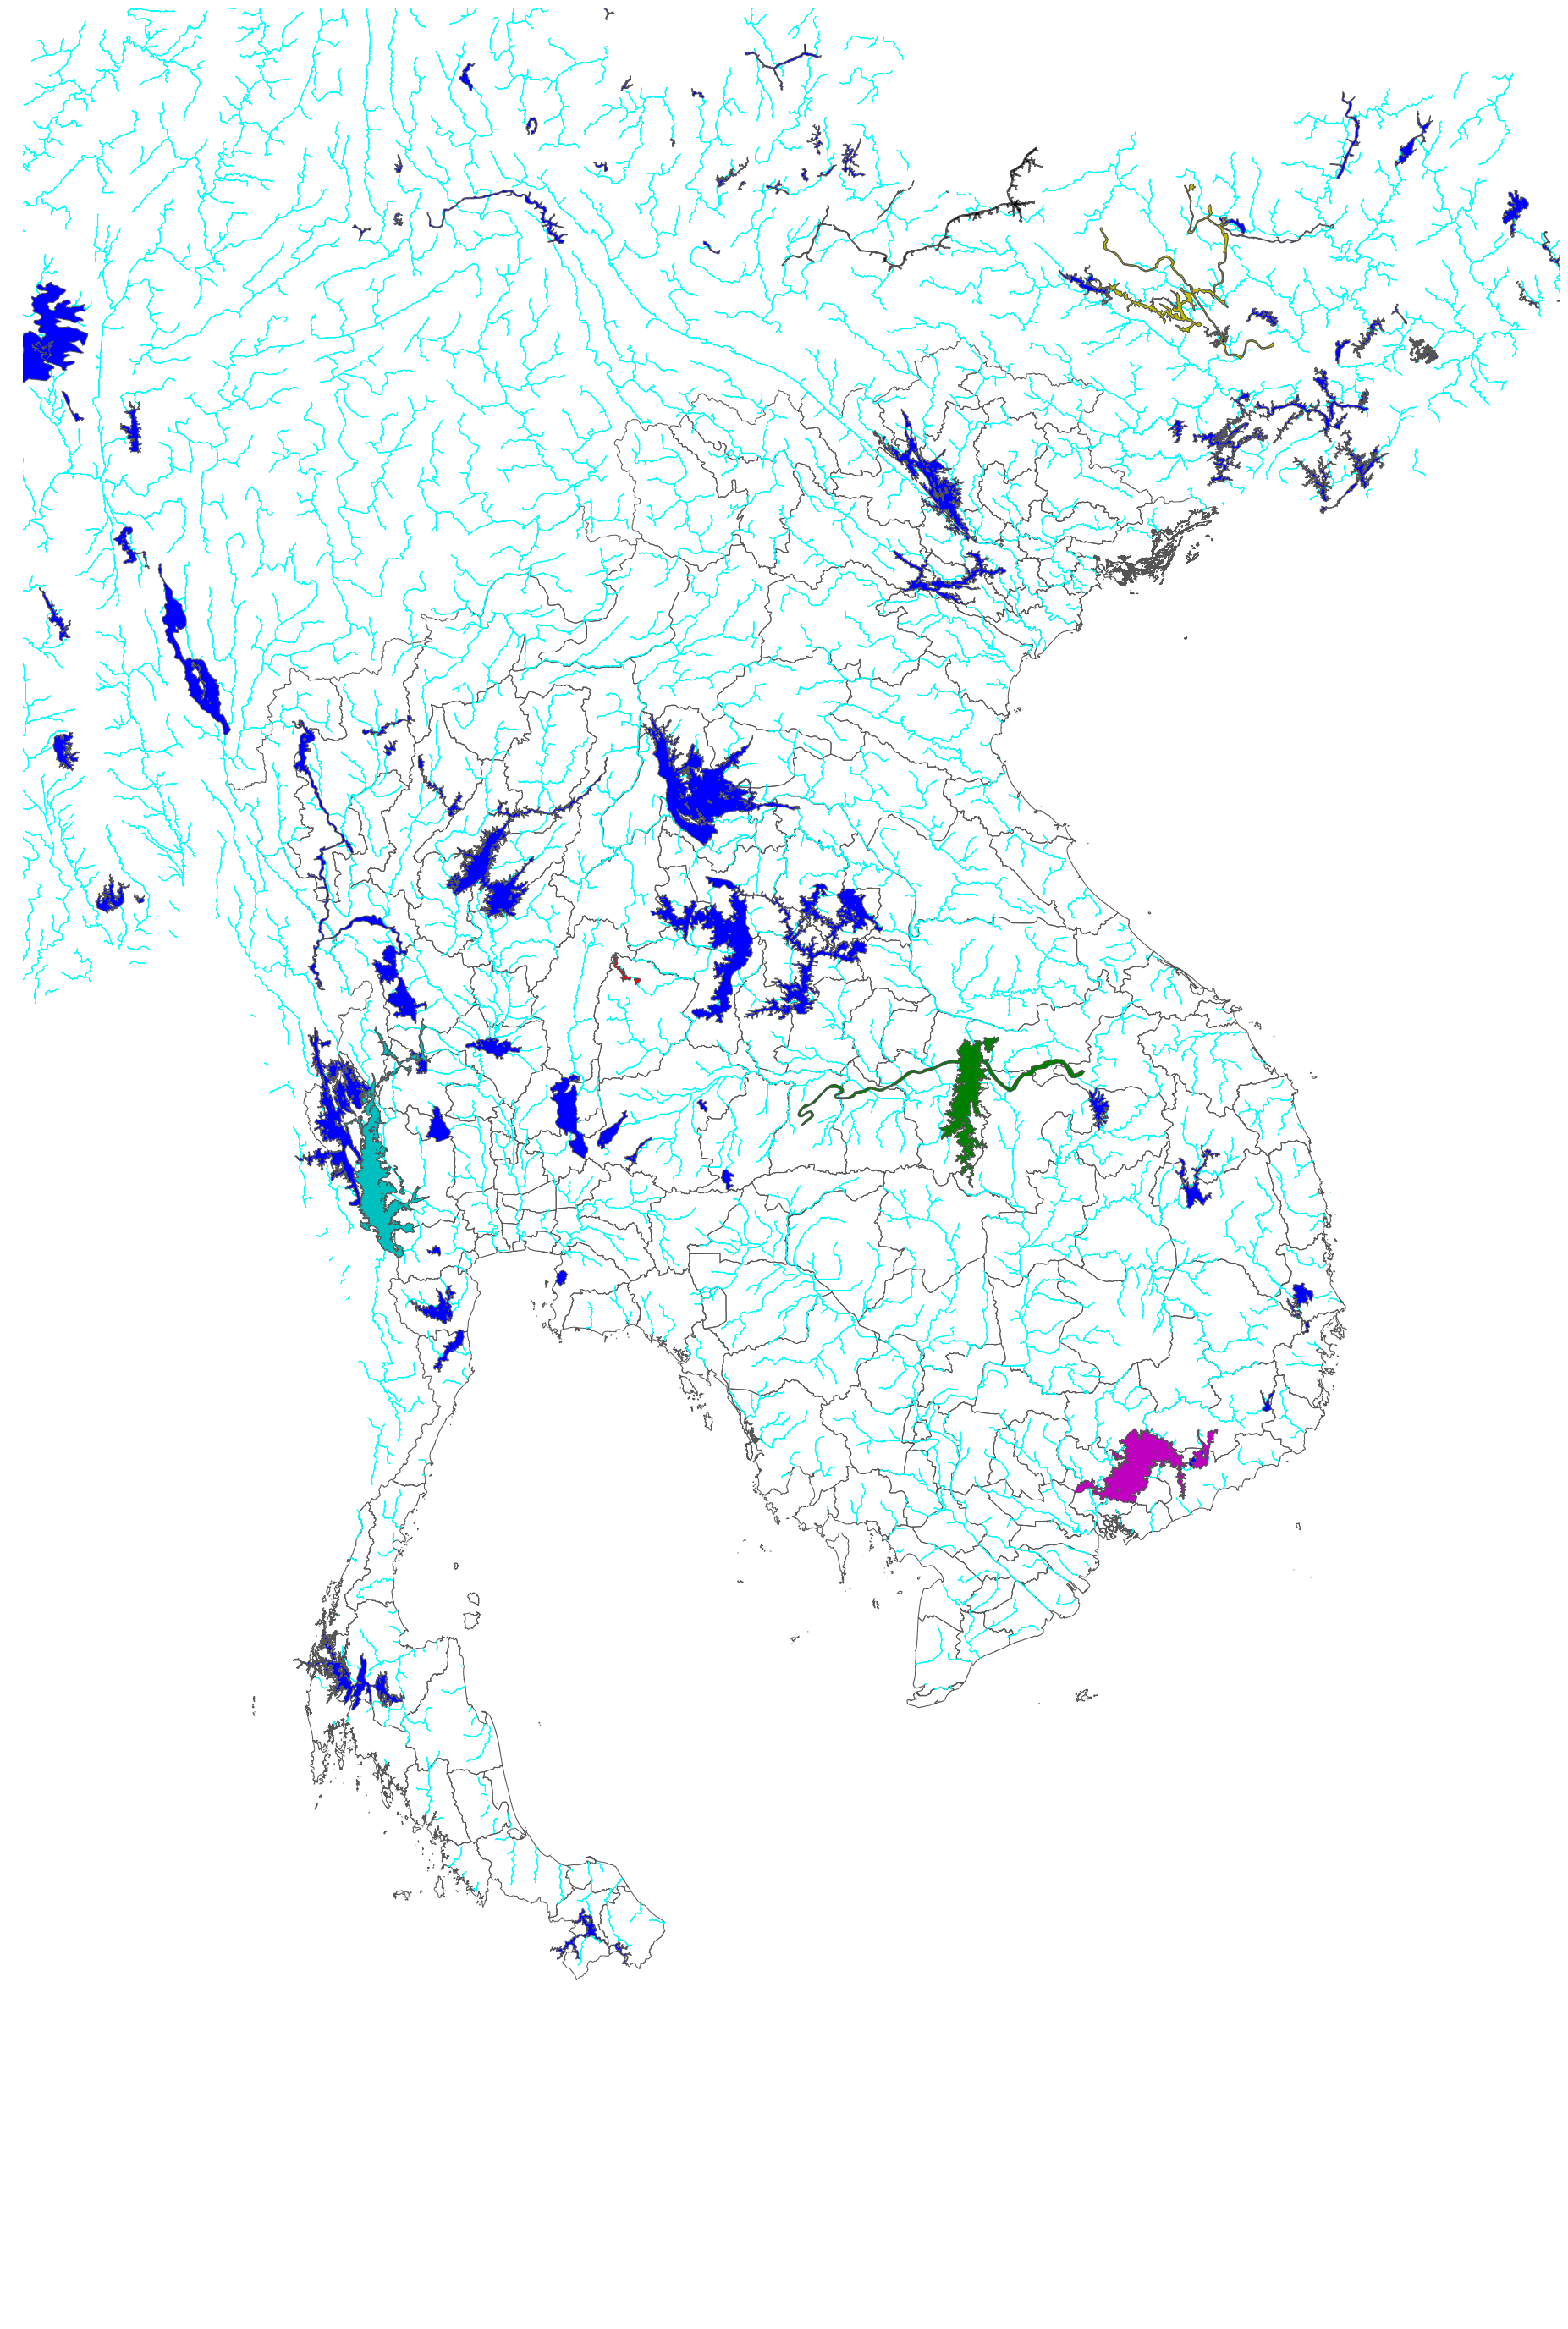

In [20]:
overlayRiversReservoirsDams_3(countryShapefile=mekongCountriesShapefile,
                           riversShapefile=rivers,
                           reservoirsShapefile=aoi2Reservoirs,
                           figsize=50,
                           reservoirScale=4.0,
                           reservoirsAndDamsPerRiver=reservoirsAndDamsPerRiver)

## Very few reservoirs and dams lay on the same river. Below is list of them. 

In [21]:
for i in range(len(reservoirsAndDamsPerRiver)):
    if (len(reservoirsAndDamsPerRiver[i])) >= 2:
        print('{} - {}: '.format(i, rivers.iloc[i]['Sub_Name']), end = '')
        print(reservoirsAndDamsPerRiver[i])
        for index in reservoirsAndDamsPerRiver[i]:
            print('{}, '.format(mekongReservoirsAndDams.iloc[index]['local_name']), end = '')
        print()

1159 - Nam Chi: [86, 87]
nan, nan, 
1309 - Nam Mun: [105, 106]
nan, nan, 
2404 - MaeKhlong: [96, 98]
nan, nan, 
2874 - Lagna Da Rgna: [112, 114]
nan, nan, 
3235 - Hongshiu He2: [32, 37]
nan, nan, 
4216 - Nanpan Jiang2: [19, 27]
nan, nan, 


In [22]:
aoi2Reservoirs['geometry']

0      POLYGON ((103.5059779188368 27.46958767361123,...
1      POLYGON ((101.4900113932289 26.88874837239587,...
2      POLYGON ((103.4312811957465 26.37319091796877,...
3      POLYGON ((99.98315356996324 26.29240678320178,...
4      POLYGON ((99.94647659513686 26.17151051584068,...
5      POLYGON ((101.6902703867682 26.14598537535586,...
6      POLYGON ((102.4420936414929 26.03209364149303,...
7      POLYGON ((100.6533264160153 25.69314751519093,...
8      POLYGON ((103.7073624674479 25.6143538411458, ...
9      POLYGON ((102.1748664008246 25.50236653645823,...
10     POLYGON ((103.7475040690103 25.46059461805547,...
11     POLYGON ((104.1439103037411 25.33762392349172,...
12     POLYGON ((99.20981864976858 25.29479967285144,...
13     POLYGON ((101.4124000379772 25.24204101562491,...
14     POLYGON ((103.8695285373263 25.20396864149299,...
15     POLYGON ((103.6097398920987 25.16063724638299,...
16     POLYGON ((102.8647205023711 25.20895990688901,...
17     POLYGON ((102.9376467556

In [23]:
mekongReservoirsAndDams['geometry']

0      POLYGON ((103.5059779188368 27.46958767361123,...
1      POLYGON ((101.4900113932289 26.88874837239587,...
2      POLYGON ((103.4312811957465 26.37319091796877,...
3      POLYGON ((99.98315356996324 26.29240678320178,...
4      POLYGON ((99.94647659513686 26.17151051584068,...
5      POLYGON ((101.6902703867682 26.14598537535586,...
6      POLYGON ((102.4420936414929 26.03209364149303,...
7      POLYGON ((100.6533264160153 25.69314751519093,...
8      POLYGON ((103.7073624674479 25.6143538411458, ...
9      POLYGON ((102.1748664008246 25.50236653645823,...
10     POLYGON ((103.7475040690103 25.46059461805547,...
11     POLYGON ((104.1439103037411 25.33762392349172,...
12     POLYGON ((99.20981864976858 25.29479967285144,...
13     POLYGON ((101.4124000379772 25.24204101562491,...
14     POLYGON ((103.8695285373263 25.20396864149299,...
15     POLYGON ((103.6097398920987 25.16063724638299,...
16     POLYGON ((102.8647205023711 25.20895990688901,...
17     POLYGON ((102.9376467556

In [24]:
mekongDams['geometry']

0      POINT (99.14730000000006 26.33679999999999)
1                         POINT (100.0656 25.5763)
2               POINT (100.0914 24.70500000000008)
3      POINT (101.1470000000001 21.78000000000005)
4      POINT (100.0306000000001 25.56380000000004)
5               POINT (102.1128690000001 20.78441)
6             POINT (100.462898 21.78222999999999)
7      POINT (100.9379120000001 21.84386099999998)
8                POINT (100.914 21.86140000000005)
9                POINT (100.914 21.86140000000005)
10     POINT (100.7820430000001 21.91246000000007)
11     POINT (100.2830730000001 21.91831000000004)
12     POINT (100.9678730000001 21.92233100000004)
13            POINT (100.939194 21.92350000000004)
14     POINT (101.0056080000001 21.93269899999999)
15     POINT (100.1827000000001 25.57070000000002)
16     POINT (98.74613200000002 28.60868100000005)
17     POINT (100.7670000000001 22.05310000000004)
18     POINT (100.9497990000001 22.07276000000001)
19     POINT (100.9227370000001

In [25]:
aoi2Reservoirs['geometry']

0      POLYGON ((103.5059779188368 27.46958767361123,...
1      POLYGON ((101.4900113932289 26.88874837239587,...
2      POLYGON ((103.4312811957465 26.37319091796877,...
3      POLYGON ((99.98315356996324 26.29240678320178,...
4      POLYGON ((99.94647659513686 26.17151051584068,...
5      POLYGON ((101.6902703867682 26.14598537535586,...
6      POLYGON ((102.4420936414929 26.03209364149303,...
7      POLYGON ((100.6533264160153 25.69314751519093,...
8      POLYGON ((103.7073624674479 25.6143538411458, ...
9      POLYGON ((102.1748664008246 25.50236653645823,...
10     POLYGON ((103.7475040690103 25.46059461805547,...
11     POLYGON ((104.1439103037411 25.33762392349172,...
12     POLYGON ((99.20981864976858 25.29479967285144,...
13     POLYGON ((101.4124000379772 25.24204101562491,...
14     POLYGON ((103.8695285373263 25.20396864149299,...
15     POLYGON ((103.6097398920987 25.16063724638299,...
16     POLYGON ((102.8647205023711 25.20895990688901,...
17     POLYGON ((102.9376467556

In [26]:
listCenters = [p.centroid for p in aoi2Reservoirs['geometry']]

In [187]:
def calculateDistanceWeight(listPoints, useDefault=True):
    if not os.path.isfile('weight_distance.csv') or not useDefault:
        from haversine import haversine
        nReservoirs = len(listPoints)
        weight_distance = np.zeros((nReservoirs, nReservoirs), dtype = np.float)
        for i in range(nReservoirs):
            pi = (listCenters[i].x, listCenters[i].y)
            for j in range(i):
                pj = (listCenters[j].x, listCenters[j].y)
                weight_distance[i,j] = weight_distance[j,i] = haversine(pi, pj)
        np.savetxt('weight_distance.csv', weight_distance)
        return weight_distance
    else:
        return np.loadtxt('weight_distance.csv')

In [188]:
weight_distance = calculateDistanceWeight(listCenters)

In [189]:
weight_distance

array([[  0.        , 227.03958328,  33.18362056, ..., 684.27729787,
        679.28136809, 622.39733402],
       [227.03958328,   0.        , 210.66752775, ..., 833.22757579,
        826.54963268, 758.82702939],
       [ 33.18362056, 210.66752775,   0.        , ..., 672.25787412,
        666.90297501, 607.66738519],
       ...,
       [684.27729787, 833.22757579, 672.25787412, ...,   0.        ,
          9.39873022,  85.5197465 ],
       [679.28136809, 826.54963268, 666.90297501, ...,   9.39873022,
          0.        ,  76.55092155],
       [622.39733402, 758.82702939, 607.66738519, ...,  85.5197465 ,
         76.55092155,   0.        ]])

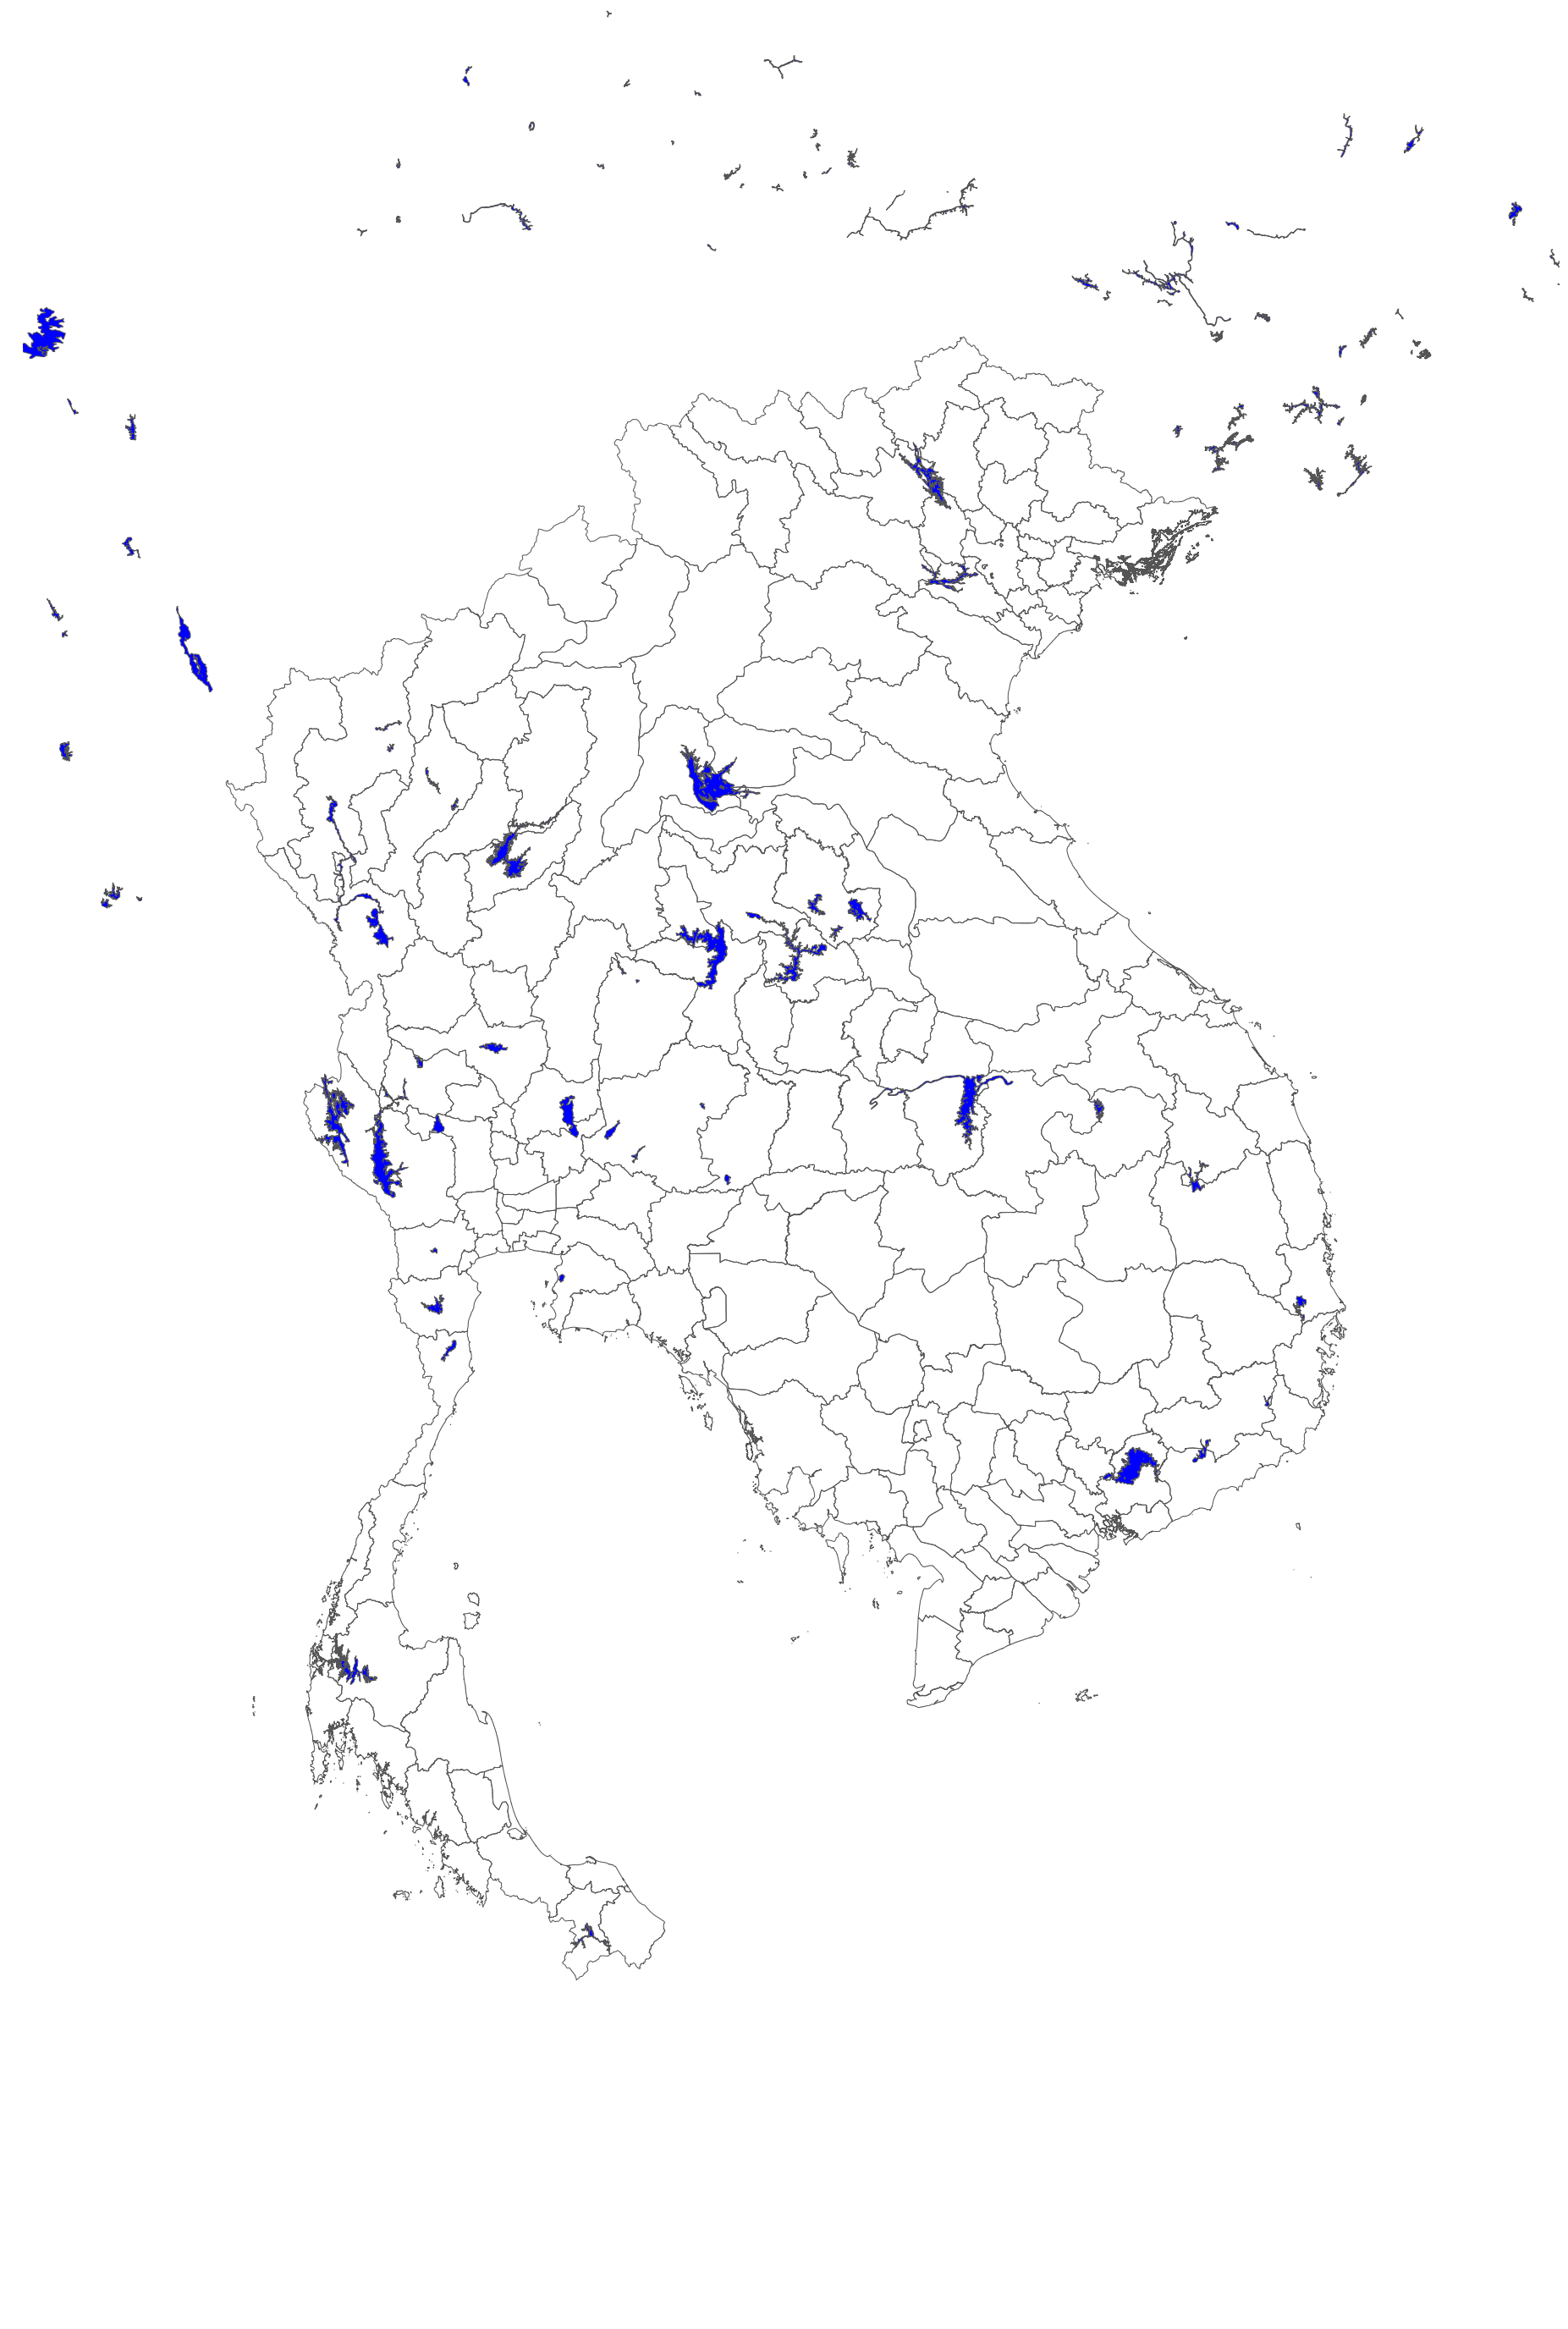

In [68]:
overlayRiversReservoirsDams_2(countryShapefile=mekongCountriesShapefile,
                           reservoirsShapefile=aoi2Reservoirs,
                           figsize=50,
                           reservoirScale=2.0)

In [70]:
aoi2Reservoirs[aoi2Reservoirs['ISO_CC'] == 'VN']

FID_AOI2_C  COUNTRY ISO_CC COUNTRYAFF CONTINENT     Land_Type  Land_Rank  \
107          15  Vietnam     VN    Vietnam      Asia  Primary land          5   
108          15  Vietnam     VN    Vietnam      Asia  Primary land          5   
109          15  Vietnam     VN    Vietnam      Asia  Primary land          5   
110          15  Vietnam     VN    Vietnam      Asia  Primary land          5   
111          15  Vietnam     VN    Vietnam      Asia  Primary land          5   
112          15  Vietnam     VN    Vietnam      Asia  Primary land          5   
113          15  Vietnam     VN    Vietnam      Asia  Primary land          5   
114          15  Vietnam     VN    Vietnam      Asia  Primary land          5   

     FID_GRanD_  GRAND_ID  AREA_SKM POLY_SRC  \
107        5778      5779     166.1     SWBD   
108        5781      5782      91.1     SWBD   
109        5797      5798      45.4     SWBD   
110        5798      5799      33.1   McGill   
111        5799      5800       8.0     SWBD   
112        5800      5801      28.6   McGill   
113        5801      5802       7.6   McGill   
114        5802      5803     277.4     SWBD   

                                              geometry  
107  POLYGON ((104.8553884548571 22.05572211371576,...  
108  POLYGON ((105.2037500000023 20.72736122776885,...  
109  POLYGON ((107.8698350016265 14.3929064941411, ...  
110  POLYGON ((108.9711682807065 12.94358886718798,...  
111  POLYGON ((108.6085285780154 11.87520779079888,...  
112  POLYGON ((107.9305254513486 11.36733067551805,...  
113  POLYGON ((107.8648082299042 11.27574853071624,...  
114  POLYGON ((107.0371155463313 11.11694444444466,...

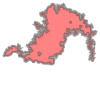

In [85]:
aoi2Reservoirs.iloc[114]['geometry']

In [198]:
def overlayReservoirsDams(countryShapefile, 
                        reservoirsShapefile=None, 
                        damsShapefile=None, 
                        ax=None, 
                        figsize=20, 
                        reservoirScale=1.0):
    
    from matplotlib.collections import PatchCollection
    from shapely.geometry import Polygon, MultiPolygon, shape, box, Point
    from shapely.affinity import scale
    from descartes import PolygonPatch
    from matplotlib import pyplot as plt

    if ax is None:
        fig = plt.figure(figsize = (figsize,figsize))
        ax = fig.add_subplot(111)

    shapes = [shape(p) for p in countryShapefile['geometry']]
    mp = MultiPolygon(shapes)
    xmin, ymin, xmax, ymax = mp.bounds
    w, h = xmax - xmin, ymax - ymin

    ax.set_xlim(xmin - 0.2 * w, xmax + 0.2 * w)
    ax.set_ylim(ymin - 0.2 * h, ymax + 0.2 * h)
    ax.set_aspect(1.0)

    listCenters = [p.centroid for p in reservoirsShapefile['geometry']]
    nReservoirs = len(listCenters)
    reservoirArea = [reservoirsShapefile.iloc[i]['geometry'].area for i in range(nReservoirs)]
    listReservoirIndexAndArea = list(zip(range(nReservoirs), reservoirArea))
    listReservoirIndexAndArea = sorted(listReservoirIndexAndArea, key=lambda x: x[1])
    weight_distance = calculateDistanceWeight(listCenters, useDefault=True)
    
    patches = []
    for provinceShape in shapes:
        patches.append(PolygonPatch(provinceShape, fc='none', ec='grey', zorder=0))
    
    if reservoirsShapefile is not None:
        for reservoirShapefile in reservoirsShapefile['geometry']:
            p = shape(reservoirShapefile)
            p = scale(p, xfact=reservoirScale, yfact=reservoirScale)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
    
    if damsShapefile is not None:
        for damShapefile in damsShapefile['geometry']:
            p = shape(damShapefile)
            p = p.buffer(0.05)
            patches.append(PolygonPatch(p, fc='blue', ec='#555555', zorder=1))
     
    '''
    for p in listCenters:
        p = shape(p).buffer(0.05)
        patches.append(PolygonPatch(p, fc='red', ec='#555555', zorder=1))
    '''
    
    p = PatchCollection(patches, match_original=True)
    ax.add_collection(p)
    
    p = [listCenters[114].x, listCenters[114].y]
    ax.plot(p[0], p[1], marker='o', color='red')
    
    color = ['r', 'orange', 'black', 'g', 'aqua']
    plotList = [x[0] for x in listReservoirIndexAndArea[-5:]]
    for j, i in enumerate(plotList):
        q = [listCenters[i].x, listCenters[i].y]
        print(str(i) + ' - ' + str(weight_distance[114, i]))
        p1 = [p[0], q[0]]
        p2 = [p[1], q[1]]
        l = mlines.Line2D(p1, p2, color = color[j])
        ax.add_line(l)
    
    ax.axis('off')
    
    plt.show()
    return ax

94 - 963.1925935742831
84 - 537.0042031750926
96 - 903.0344290027525
60 - 1329.6738007234699
57 - 544.3846366800523


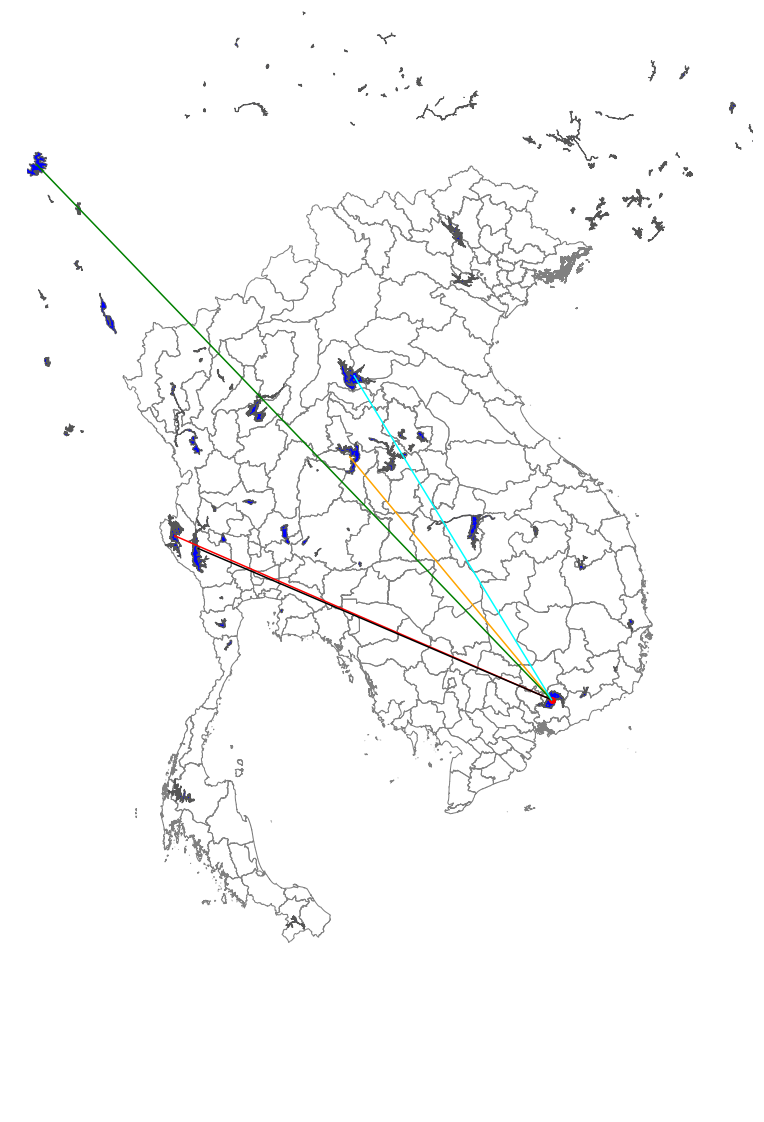

In [199]:
overlayReservoirsDams(mekongCountriesShapefile,
                     aoi2Reservoirs,
                     reservoirScale=2.0)

In [140]:
aoi2Reservoirs.iloc[114]['geometry'].area

0.022868949898491975

In [160]:
aoi2Reservoirs.iloc[26]['geometry'].area

8.496476804415242e-06

In [154]:
reservoirCenterAndArea = list(zip(listCenters, reservoirArea))

In [155]:
reservoirCenterAndArea[0]

(<shapely.geometry.point.Point at 0x7fc8b4f44ba8>, 0.0006453263412666457)

In [177]:
weight_distance[114]

array([622.39733402, 758.82702939, 607.66738519, 884.63146043,
       885.50671488, 731.48973039, 668.21328396, 814.86913211,
       570.52995405, 680.78904389, 565.05513941, 539.32925393,
       946.52584633, 742.55905828, 553.23269412, 567.59786905,
       625.25507904, 614.00173511, 585.37696032, 503.30245928,
       941.69828948, 832.64648148, 979.67614457, 628.30517556,
       609.90999267, 562.65390517, 479.62875169, 485.33896179,
       674.25334748, 468.47044604, 486.68610989, 698.99455918,
       431.28531036, 417.05048696, 412.42434382, 662.63482317,
       418.02671689, 427.00359883, 544.53443728, 451.07545615,
       513.02981763, 422.87183465, 549.99907185, 543.04074319,
       489.50610122, 553.31603896, 490.06156939, 450.83839337,
       404.06314909, 465.68748312, 375.85657829, 391.20459857,
       395.67413611, 379.91448155, 465.407817  , 460.00929676,
       429.54759143,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

In [190]:
weight_distance[-1]

array([ 622.39733402,  758.82702939,  607.66738519,  884.63146043,
        885.50671488,  731.48973039,  668.21328396,  814.86913211,
        570.52995405,  680.78904389,  565.05513941,  539.32925393,
        946.52584633,  742.55905828,  553.23269412,  567.59786905,
        625.25507904,  614.00173511,  585.37696032,  503.30245928,
        941.69828948,  832.64648148,  979.67614457,  628.30517556,
        609.90999267,  562.65390517,  479.62875169,  485.33896179,
        674.25334748,  468.47044604,  486.68610989,  698.99455918,
        431.28531036,  417.05048696,  412.42434382,  662.63482317,
        418.02671689,  427.00359883,  544.53443728,  451.07545615,
        513.02981763,  422.87183465,  549.99907185,  543.04074319,
        489.50610122,  553.31603896,  490.06156939,  450.83839337,
        404.06314909,  465.68748312,  375.85657829,  391.20459857,
        395.67413611,  379.91448155,  465.407817  ,  460.00929676,
        429.54759143,  544.38463668,  513.48711634,  131.83439

In [186]:
weight_distance[0]

array([   0.        ,  227.03958328,   33.18362056,  396.54696568,
        399.30615356,  207.47353409,  124.74759006,  321.94957197,
         52.71904706,  157.28116833,   57.88135024,   87.32996227,
        481.9679095 ,  241.90603012,   69.22354192,   60.68463503,
         98.01210393,   90.39871647,   67.11188893,  136.54722957,
        483.66697511,  359.31799637,  527.40746623,  129.03859681,
        743.79319304,  663.0027666 ,  193.35393269,  169.00530244,
        868.36705695,  531.17536215,  582.89894299,  921.48935158,
        451.59943862,  361.2972042 ,  387.21048828,  886.6842536 ,
        455.90953058,  480.37462751,  734.20570336,  572.33229808,
        698.58971904,  519.81104077,  756.74717014,  751.26103473,
        668.47010754,  766.79536761,  697.27006632,  636.41780644,
        549.71415328,  671.45866281,  481.91228829,  541.83907677,
        553.87190884,  529.92744775,  692.92527276,  694.57239849,
        647.05797366,  243.49014116,  237.3359926 ,  509.84848